# 4. Model Development

## Pre-processing

In [24]:
# Libraries imported for this notebook.

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_Pre_Process_Train into a dataframe, formatted dates, and indexed dates.

mean_df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned_Pre_Process_Train.xlsx', parse_dates=True, index_col=[0])

In [38]:
# Looked at shape

mean_df.shape

(1092, 465)

In [3]:
# Defined Xs and y.
X_lag = mean_df.drop(columns=['phycocyanin_lag_00']).drop(columns=mean_df.filter(like='nl_').columns) # Original metric lags
X_dif_nl_lag = mean_df.loc[:, mean_df.columns.str.contains('dif_nl_')] # 1st order differenced, natural logged, and all lag versions of metrics
y = mean_df['phycocyanin_lag_00'] # Target variable, original phycocyanin

Next, I created a function into which I can enter the features, target variable, type of model, and model name. I will try original data with lagged features and differenced and natural logged data with lagged features in combination with multiple models. Each model will be run multiple times with starting with including no lagged data and then adding a level of lagged data each time it's run. The RMSE with be graphed and the lowest RMSE score from all models will be chosen as the final model.

I used TimeSeriesSplit in the function as a cross-validator because it is specifically designed for time series data. The dataset is split into consecutive folds, where each fold is a superset of the previous one, ensuring that the model is trained on data that retains the temporal nature of time series data.

In [4]:
# Initialize TimeSeriesSplit with number of splits equal to 5

tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Updated function to dynamically generate lag suffixes
def fit_model(X, y, model, model_name, max_lags=20):
    
    # Initialize lists to store RMSE values for each lag suffix
    lag_rmse = []
    lag_rmse_std = []  # Store standard deviation of RMSE for error bars
    
    # Iterate through each lag suffix to gradually include more features
    for lag in range(max_lags + 1):  # Start from 0 lags
        lag_features_to_include = [col for col in X.columns if col.endswith("lag_00")]
        
        # Include additional lag features up to the current lag
        for i in range(1, lag + 1):
            lag_suffix = str(i).zfill(2)
            lag_features_to_include += [col for col in X.columns if col.endswith(f"lag_{lag_suffix}")]
        
        overall_rmse_for_suffix = []

        # Iterate through each fold
        for j, (train_index, test_index) in enumerate(tscv.split(X)):
            train_dates = X.index[train_index]
            test_dates = X.index[test_index]

            X_train, X_test = X.loc[train_dates, lag_features_to_include], X.loc[test_dates, lag_features_to_include]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model on the training data for this fold
            model.fit(X_train, y_train)

            # Make predictions on the testing data for this fold
            y_pred = model.predict(X_test)

            # Calculate RMSE for this fold
            rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
            overall_rmse_for_suffix.append(rmse_fold)

        # Calculate and print the overall RMSE for this lag suffix
        overall_rmse = np.mean(overall_rmse_for_suffix)
        lag_rmse.append(overall_rmse)
        
        # Calculate standard deviation of RMSE
        lag_rmse_std.append(np.std(overall_rmse_for_suffix))
        
        print(f"RMSE for {model_name} with {lag} lags included: {overall_rmse}")

    # Plotted the RMSE values for each lag suffix with error bars
    plt.errorbar(range(max_lags + 1), lag_rmse, yerr=lag_rmse_std, fmt='o', capsize=5)
    plt.title(f"RMSE for {model_name} by number of lags included")
    plt.xlabel("Number of Lags")
    plt.ylabel("RMSE")
    plt.xticks(range(max_lags + 1))
    plt.grid(True)
    plt.show()

Models capable of making predictions from time series data were essential for this project. I chose to explore linear regression, random forest, and LightGBM models.

In [39]:
# Created a baseline model.

# Calculated the predicted phycocyanin values for each half-hour interval
predicted_phycocyanin = np.array(mean_df['phycocyanin_lag_01'])

# Shifted the actual phycocyanin values by one interval to align with predictions
actual_phycocyanin = np.array(mean_df['phycocyanin_lag_00'])

# Calculated RMSE for the baseline model
rmse_base = np.sqrt(mean_squared_error(actual_phycocyanin, predicted_phycocyanin))
print("Root Mean Squared Error (RMSE) for the baseline model:", rmse_base)

Root Mean Squared Error (RMSE) for the baseline model: 29.841813952071398


## Linear Regression

RMSE for Linear regression with 0 lags included: 86.44738920731855
RMSE for Linear regression with 1 lags included: 28.9999817520903
RMSE for Linear regression with 2 lags included: 32.17541005574412
RMSE for Linear regression with 3 lags included: 30.859541726729823
RMSE for Linear regression with 4 lags included: 28.874219967636026
RMSE for Linear regression with 5 lags included: 27.10445727134216
RMSE for Linear regression with 6 lags included: 26.204256626453862
RMSE for Linear regression with 7 lags included: 26.806352571257605
RMSE for Linear regression with 8 lags included: 28.022015423465273
RMSE for Linear regression with 9 lags included: 27.599734030264823
RMSE for Linear regression with 10 lags included: 29.782673129163527
RMSE for Linear regression with 11 lags included: 32.44938894488109
RMSE for Linear regression with 12 lags included: 34.19745259255334
RMSE for Linear regression with 13 lags included: 33.38333715442047
RMSE for Linear regression with 14 lags included: 34

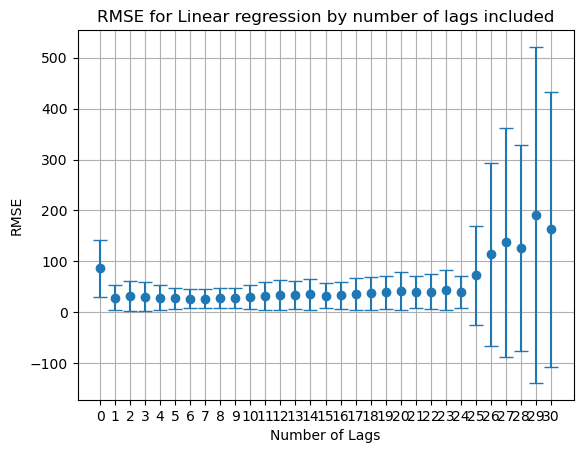

In [16]:
# Used function to run linear regression models using the original metrics and lags.

fit_model(X_lag, y, LinearRegression(), "Linear regression")

RMSE for Linear regression using differenced and logged metrics with 0 lags included: 144.76918929798384
RMSE for Linear regression using differenced and logged metrics with 1 lags included: 144.91325860430106
RMSE for Linear regression using differenced and logged metrics with 2 lags included: 146.04356569151057
RMSE for Linear regression using differenced and logged metrics with 3 lags included: 145.58497451965889
RMSE for Linear regression using differenced and logged metrics with 4 lags included: 147.5087442936455
RMSE for Linear regression using differenced and logged metrics with 5 lags included: 147.40996650065566
RMSE for Linear regression using differenced and logged metrics with 6 lags included: 148.32606241320724
RMSE for Linear regression using differenced and logged metrics with 7 lags included: 148.79416599747424
RMSE for Linear regression using differenced and logged metrics with 8 lags included: 148.81119956553144
RMSE for Linear regression using differenced and logged 

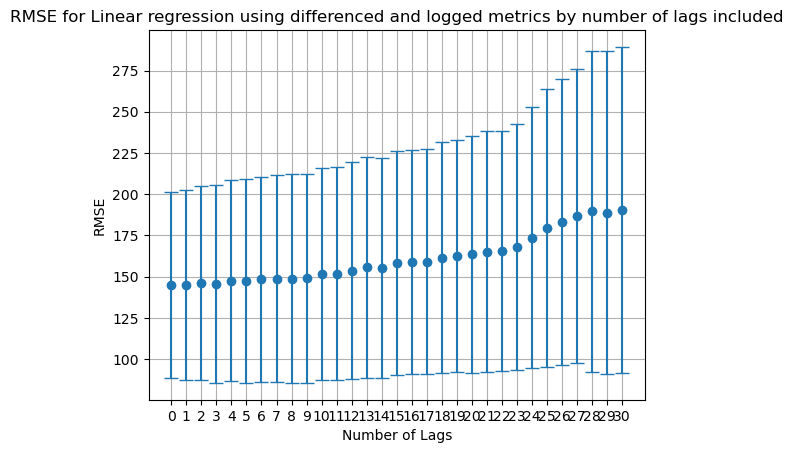

In [17]:
# Used function to run linear regression models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y, LinearRegression(), "Linear regression using differenced and logged metrics")

The error gets better as I add laged features but only up to 8 lags and the scores are still not as good as the baseline model!

In [36]:
X_lag_06_LR = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06)') & 
                           ~mean_df.columns.str.contains('nl_') & 
                           ~mean_df.columns.str.contains('phycocyanin_lag_00')]

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_22137/1956046074.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X_lag_06_LR = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06)') &


In [37]:
# Set fit_intercept=False
model = LinearRegression(fit_intercept=False)

# Initialize lists to store RMSE values for each lag suffix
overall_rmse_for_suffix = []

# Iterate through each fold
for j, (train_index, test_index) in enumerate(tscv.split(X_lag_06_LR)):
    train_dates = X_lag_06_LR.index[train_index]
    test_dates = X_lag_06_LR.index[test_index]

    X_train, X_test = X_lag_06_LR.loc[train_dates], X_lag_06_LR.loc[test_dates]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data for this fold
    model.fit(X_train, y_train)

    # Make predictions on the testing data for this fold
    y_pred = model.predict(X_test)

    # Calculate RMSE for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_rmse_for_suffix.append(rmse_fold)

# Calculate and print the overall RMSE for this lag suffix
overall_rmse = np.mean(overall_rmse_for_suffix)
std_rmse = np.std(overall_rmse_for_suffix)
print(f"RMSE for Linear Regression with lag data of 0-6 days: {overall_rmse} ± {std_rmse}")

RMSE for Linear Regression with lag data of 0-6 days: 26.12393689354652 ± 18.696924237761475


## Random Forest

RMSE for Random forest with 0 lags included: 95.0236437880573
RMSE for Random forest with 1 lags included: 53.62447099643704
RMSE for Random forest with 2 lags included: 51.813232906499856
RMSE for Random forest with 3 lags included: 54.90337188584114
RMSE for Random forest with 4 lags included: 51.988906513927965
RMSE for Random forest with 5 lags included: 55.26460894891945
RMSE for Random forest with 6 lags included: 54.22840384705002
RMSE for Random forest with 7 lags included: 53.126334033646785
RMSE for Random forest with 8 lags included: 51.391647266315104
RMSE for Random forest with 9 lags included: 48.557059555517014
RMSE for Random forest with 10 lags included: 49.51371225925085
RMSE for Random forest with 11 lags included: 48.627359638071994
RMSE for Random forest with 12 lags included: 49.5494280447155
RMSE for Random forest with 13 lags included: 47.552749380149834
RMSE for Random forest with 14 lags included: 41.03096569501021
RMSE for Random forest with 15 lags included:

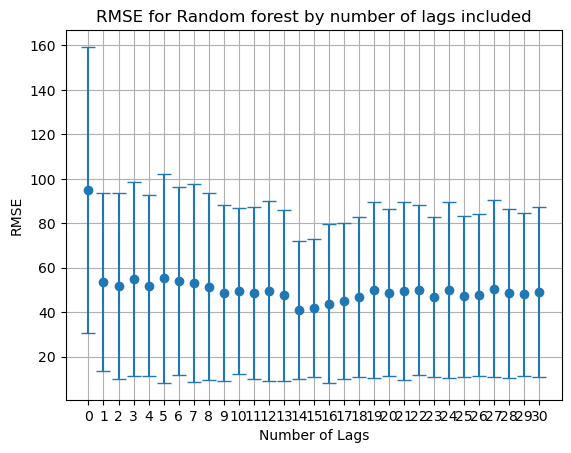

In [18]:
# Used function to run linear regression models using the original metrics and lags.

fit_model(X_lag, y, RandomForestRegressor(), "Random forest")

RMSE for Random forest using differenced and logged metrics with 0 lags included: 154.4973247887086
RMSE for Random forest using differenced and logged metrics with 1 lags included: 153.2417550959884
RMSE for Random forest using differenced and logged metrics with 2 lags included: 150.16552054531638
RMSE for Random forest using differenced and logged metrics with 3 lags included: 145.56871223263207
RMSE for Random forest using differenced and logged metrics with 4 lags included: 142.21436727388078
RMSE for Random forest using differenced and logged metrics with 5 lags included: 141.99698590201757
RMSE for Random forest using differenced and logged metrics with 6 lags included: 138.06275950038136
RMSE for Random forest using differenced and logged metrics with 7 lags included: 136.27580911133555
RMSE for Random forest using differenced and logged metrics with 8 lags included: 135.01547958166157
RMSE for Random forest using differenced and logged metrics with 9 lags included: 134.1824616

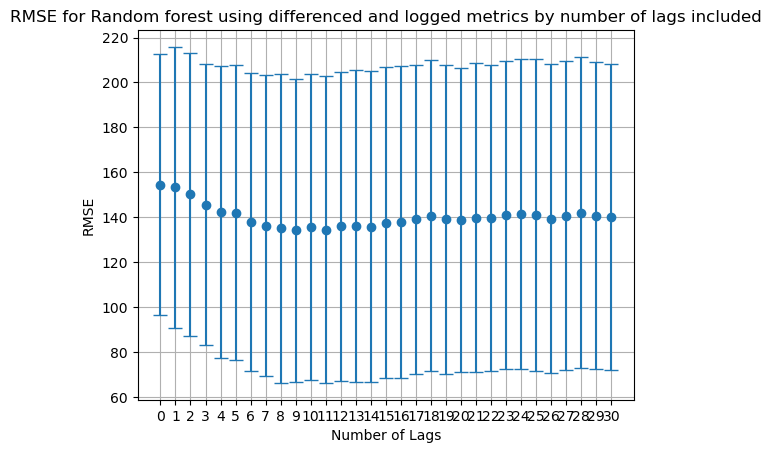

In [15]:
# Used function to run linear regression models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y, RandomForestRegressor(), "Random forest using differenced and logged metrics")

The error gets better as I add laged features but only up to 11 lags and the scores are still not as good as the baseline model!

In [19]:
X_lag_14 = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06|07|08|09|10|11|12|13|14)') & 
                           ~mean_df.columns.str.contains('nl_') & 
                           ~mean_df.columns.str.contains('phycocyanin_lag_00')]

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_22137/996363286.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X_lag_14 = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06|07|08|09|10|11|12|13|14)') &


In [10]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=10)],
    'max_depth': [3, 4, 5, 10, 15, None],
    'max_features': [1.0, 'sqrt', 0.5, 0.75],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 8]
}

# Initialize overall_rmse_for_suffix list
overall_rmse_for_suffix = []

# Iterate through each fold using TimeSeriesSplit
for j, (train_index, test_index) in enumerate(tscv.split(X_lag_14_LR)):
    train_dates = X_lag_14_LR.index[train_index]
    test_dates = X_lag_14_LR.index[test_index]

    X_train, X_test = X_lag_14_LR.loc[train_dates], X_lag_14_LR.loc[test_dates]
    y_train, y_test = y[train_index], y[test_index]

    # Create RandomForestRegressor instance
    rf = RandomForestRegressor()

    # Perform RandomizedSearchCV with time series cross-validation
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=tscv)
    rf_random.fit(X_train, y_train)

    # Make predictions on the testing data with the best model
    y_pred = rf_random.best_estimator_.predict(X_test)

    # Calculate RMSE for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_rmse_for_suffix.append(rmse_fold)

# Calculate and print the overall RMSE for this lag suffix
overall_rmse = np.mean(overall_rmse_for_suffix)
std_rmse = np.std(overall_rmse_for_suffix)
print(f"RMSE for Random Forest with lag data of 0-14 days: {overall_rmse} ± {std_rmse}")

RMSE for Random Forest with lag data of 0-6 days: 43.047968835195135 ± 28.29919420647268


## XGBoost

RMSE for XGBoost with 0 lags included: 110.018545578305
RMSE for XGBoost with 1 lags included: 83.65017566178658
RMSE for XGBoost with 2 lags included: 82.23809031352874
RMSE for XGBoost with 3 lags included: 78.31878002078597
RMSE for XGBoost with 4 lags included: 79.0573803127839
RMSE for XGBoost with 5 lags included: 77.40835715380304
RMSE for XGBoost with 6 lags included: 78.02746170512046
RMSE for XGBoost with 7 lags included: 77.74078690169614
RMSE for XGBoost with 8 lags included: 79.40583504923835
RMSE for XGBoost with 9 lags included: 76.29268655198013
RMSE for XGBoost with 10 lags included: 73.70964296879909
RMSE for XGBoost with 11 lags included: 73.46966348146407
RMSE for XGBoost with 12 lags included: 70.67819643237353
RMSE for XGBoost with 13 lags included: 69.97860186456906
RMSE for XGBoost with 14 lags included: 58.39948724708397
RMSE for XGBoost with 15 lags included: 61.48768213844137
RMSE for XGBoost with 16 lags included: 61.15076754738514
RMSE for XGBoost with 17 l

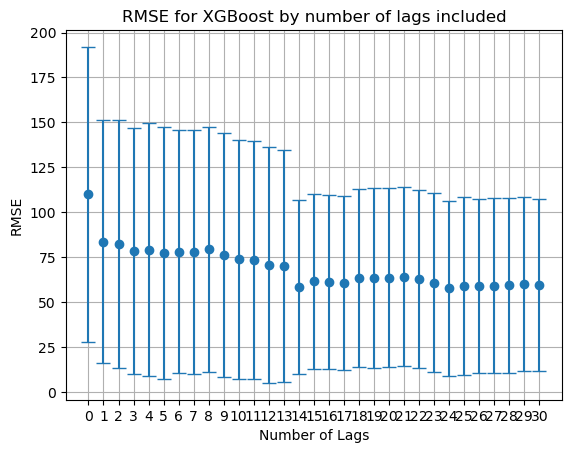

In [13]:
# Used function to run linear regression models using the original metrics and lags.

fit_model(X_lag, y, xgb.XGBRegressor(), "XGBoost")

RMSE for XGBoost using differenced and logged metrics with 0 lags included: 162.21109681811737
RMSE for XGBoost using differenced and logged metrics with 1 lags included: 160.68851530541818
RMSE for XGBoost using differenced and logged metrics with 2 lags included: 158.83068444834163
RMSE for XGBoost using differenced and logged metrics with 3 lags included: 159.02606967767173
RMSE for XGBoost using differenced and logged metrics with 4 lags included: 154.5908691131262
RMSE for XGBoost using differenced and logged metrics with 5 lags included: 152.00201325662619
RMSE for XGBoost using differenced and logged metrics with 6 lags included: 150.00974249497392
RMSE for XGBoost using differenced and logged metrics with 7 lags included: 151.91603466252366
RMSE for XGBoost using differenced and logged metrics with 8 lags included: 149.10876722186225
RMSE for XGBoost using differenced and logged metrics with 9 lags included: 147.56789036143434
RMSE for XGBoost using differenced and logged metri

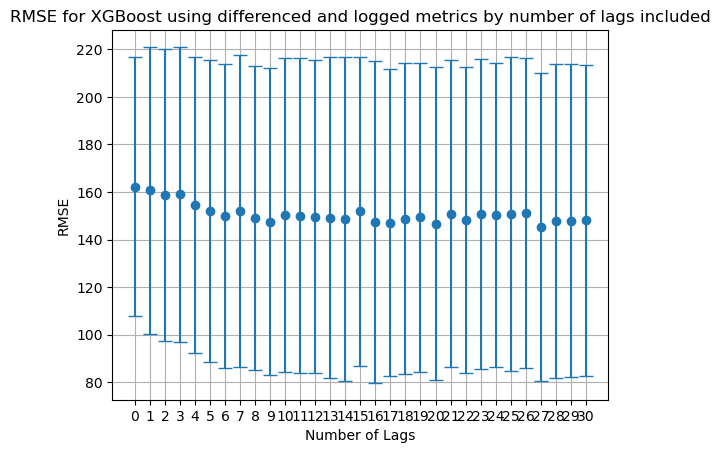

In [14]:
# Used function to run linear regression models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y, xgb.XGBRegressor(), "XGBoost using differenced and logged metrics")

In [35]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],  # Adjusted for smaller dataset
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1],
    'reg_lambda': [0.01, 0.1, 1],
    'alpha': [0, 0.1, 1]
}

# Initialize overall_rmse_for_suffix list
overall_rmse_for_suffix = []

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Iterate through each fold using TimeSeriesSplit
for j, (train_index, test_index) in enumerate(tscv.split(X_lag_14)):
    train_dates = X_lag_14.index[train_index]
    test_dates = X_lag_14.index[test_index]

    X_train, X_test = X_lag_14.loc[train_dates], X_lag_14.loc[test_dates]
    y_train, y_test = y[train_index], y[test_index]

    # Create XGBoost model without early stopping
    model = XGBRegressor(
        objective='reg:squarederror'
    )

    # Perform RandomizedSearchCV with time series cross-validation
    xg_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=tscv)
    xg_random.fit(X_train, y_train)

    # Make predictions on the testing data with the best model
    y_pred = xg_random.best_estimator_.predict(X_test)

    # Calculate RMSE for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_rmse_for_suffix.append(rmse_fold)

# Calculate and print the overall RMSE for this lag suffix
overall_rmse = np.mean(overall_rmse_for_suffix)
std_rmse = np.std(overall_rmse_for_suffix)
print(f"RMSE for XGBoost with lag data of 0-14 days: {overall_rmse} ± {std_rmse}")

RMSE for XGBoost with lag data of 0-14 days: 71.22869829673581 ± 59.576232181984864


## Conclusion

The linear regression models using the original metrics (lag_00) and lags of 1 through 6 days produced a model with a lower RMSE score, 26.20, than any other model. By setting the intercept to 0, the model wat tuned to produce an error or 26.12 ± 18.70.